In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
!pip install datasets
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from datasets import load_dataset
import math
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import random

In [2]:
def learning_curve(num_epochs, train_loss, validation_loss):
    epochs = np.arange(0,num_epochs)
    plt.xlabel("Epoch")
    plt.ylabel("Loss Function History")
    plt.plot(epochs.astype(int), train_loss, linestyle="-", color="black")
    plt.plot(epochs.astype(int), validation_loss, linestyle="-", color="magenta")
    plt.legend(['training loss','validation loss'])
    return plt

In [21]:
def classification_accuracy_curve(num_epochs, accuracy):
    epochs = np.arange(0,num_epochs)
    plt.xlabel("Epoch")
    plt.ylabel("Classification Accuracy")
    plt.plot(epochs.astype(int), accuracy, linestyle="-", color="black")
    return plt

In [3]:
dataset = load_dataset("valhalla/emoji-dataset")

In [4]:
torch.manual_seed(1)
images = []
aug_images = []
labels = []
aug_labels = []
jitter = transforms.ColorJitter(brightness=(0.8,1.2),contrast=(.5,1.5))
#higher sigma values blurs image more

for x in dataset["train"]:
    txt = x["text"]
    if "superhero" in txt:
        if txt == "superhero":
          continue

        orig = x["image"].resize((64,64))
        images.append(np.asarray(orig))
        aug_images.append(np.asarray(orig))
        label = 0
        if "woman" not in txt and "man" in txt:
          label = 1
        labels.append(label)
        aug_labels.append(label)
        # print("Original:")
        # display(orig)

        jittered_imgs = [jitter(orig) for _ in range(45)]
        for jittered_img in jittered_imgs:
          aug_images.append(np.asarray(jittered_img))
          aug_labels.append(label)
          # display(jittered_img)
          blurrer = transforms.GaussianBlur(kernel_size=(5, 5), sigma=(random.uniform(0,.1)))

          blurred_img = blurrer(jittered_img)
          rotated_img = blurred_img.rotate(random.randint(-1, 1))

          aug_images.append(np.asarray(rotated_img))
          aug_labels.append(label)
          # display(rotated_img)


In [5]:
len(images), len(aug_images), len(aug_labels)

(12, 1092, 1092)

In [6]:
class autoencoder(torch.nn.Module):
  def __init__(self, kernel_size, stride, padding, latent_rep_size, in_dims=[64, 64]):
    super().__init__()

    l1_out_dims = self.conv2d_output_dims(in_dims, kernel_size, stride, padding)
    l2_out_dims = self.conv2d_output_dims(l1_out_dims, kernel_size, stride, padding)
    l3_out_dims = self.conv2d_output_dims(l2_out_dims, kernel_size, stride, padding)
    l4_out_dims = self.conv2d_output_dims(l3_out_dims, kernel_size, stride, padding)

    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(3,128,kernel_size,stride, padding),
        torch.nn.ReLU(),
        torch.nn.Conv2d(128,256,kernel_size,stride, padding),
        torch.nn.ReLU(),
        torch.nn.Conv2d(256,512,kernel_size,stride, padding),
        torch.nn.ReLU(),
        torch.nn.Conv2d(512,1024,kernel_size,stride, padding),
        torch.nn.Flatten(),
        torch.nn.Linear(1024 * l4_out_dims[0] * l4_out_dims[1], latent_rep_size)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(latent_rep_size, 1024 * l4_out_dims[0] * l4_out_dims[1]),
        torch.nn.Unflatten(1, torch.Size([1024, l4_out_dims[0], l4_out_dims[1]])),
        torch.nn.ConvTranspose2d(1024,512,kernel_size,stride, padding),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(512,256,kernel_size,stride, padding),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(256,128,kernel_size,stride, padding),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(128,3,kernel_size,stride, padding),
        torch.nn.Sigmoid()
    )

    self.classify = torch.nn.Sequential(
        torch.nn.Linear(latent_rep_size, 1),
        torch.nn.Sigmoid()
    )



  # Helper to calculate output height and widths of each conv2d layer
  def conv2d_output_dims(self, input_dims, kernel_size, stride, padding):
    h_out = ((input_dims[0] + 2 * padding - kernel_size) // stride) + 1
    w_out = ((input_dims[1] + 2 * padding - kernel_size) // stride) + 1
    return [h_out, w_out]

  def encode(self, x):
    return self.encoder(x)

  def decode(self, x):
    return self.decoder(x)

  def forward(self, x, classify=False):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    if classify:
      y_h = self.classify(encoded)
      return decoded, y_h
    else:
      return decoded

  def combine(self, l):
    tmp = None
    for x in l:
      if tmp == None:
        tmp = self.encoder(x)
      else:
        tmp += self.encoder(x)
    tmp /= len(l)
    decoded = self.decoder(tmp)
    return decoded


In [7]:
train, temp = train_test_split(aug_images,test_size=0.4, random_state=1)
train_label, temp_label = train_test_split(aug_labels,test_size=0.4, random_state=1)
test, validation = train_test_split(temp,test_size=0.5, random_state=1)
test_label, validation_label = train_test_split(temp_label,test_size=0.5, random_state=1)

In [8]:
len(train),len(test),len(validation),len(train_label),len(test_label),len(validation_label)

(655, 218, 219, 655, 218, 219)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Training autoencoder without using gender classifier

Our dataset is the superhero dataset. We grabbed the dataset from “valhalla/emoji-dataset” and compiled all entries with tags containing “superhero” in dataset[“train”][“text”]. We randomly changed the brightness and contrast for each emoji and for each of those, we blurred them with randomly chosen Gaussian blur and rotated them by a random degree. Our architecture is taken from (https://arxiv.org/pdf/1511.06434.pdf). For our autoencoder, using subsequent convolutional layers, we take in a 64x64x3 image into representations of 128, 256, 512, 1024 channels (with the other two dimensions relying on the kernel_size and stride). We use ReLU and Sigmoid activations. We modeled our architecture against the paper’s model because the assignment suggested this. Our architecture choice ultimately proved to be successful, as we were able to build a functioning autoencoder. One decision we made was initially dividing the RGB values by 255 and having our decoder layer do a sigmoid on the output and finally multiplying by 255 after the decoding. This allows us to avoid clipping values manually at the end. We allowed kernel_size, stride, and latent representation size to be modifiable (rather than being hard-coded as in the paper’s architecture), which required us to calculate the output sizes of each convolutional layer.

Hyperparameters:
kernel_size = 2  
stride = 2   
padding = 0  
learning_rate = 0.0002   
batch_size = 65  
num_epochs = 300

The final average training & test loss can be seen in the output of the cell below:
Final Train Loss: 0.000162440279382281  
Final Test Loss: 0.0002886498987209052

We noticed that as we increased the number of epochs, our loss decreased. We also noticed that the more we augmented our data, the more epochs we needed in order to achieve equivalent losses. Training in mini-batches increased the performance of our model (perhaps this is because we do not need to make as many memory transactions).




In [34]:
AEModel = autoencoder(2, 2, 0, 100)
AEModel.to(device)
num_epochs = 300
loss_func1 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(AEModel.parameters(), lr=0.0002)
lamb = 0.1
avg_train_loss = []
avg_val_loss = []

num_batches = 10
batch_size = len(train) // num_batches
train_image_tensors = [torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)/255 for image in train]

### TRAINING
for i in range(num_epochs):
  train_loss = 0

  for batch_num in range(num_batches):
    image_idx = batch_num * batch_size
    image_tensor_batch = train_image_tensors[image_idx:image_idx + batch_size]
    image_tensor_batch = torch.cat(image_tensor_batch, dim=0)
    image_tensor_batch = image_tensor_batch.to(device)
    output= AEModel.forward(image_tensor_batch)
    loss = loss_func1(output, image_tensor_batch)
    train_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  avg_train_loss.append((train_loss/num_batches).item())
  #validation loss
  val_loss = 0
  for val_image in validation:
    # Reformat into the same format expected by nn.conv2d
    val_image_tensor = torch.Tensor(val_image).permute(2, 0, 1).unsqueeze(0)
    val_image_tensor /= 255
    val_image_tensor = val_image_tensor.to(device)
    val_output= AEModel.forward(val_image_tensor)
    val_loss += loss_func1(val_output, val_image_tensor)
  avg_val_loss.append((val_loss/len(validation)).item())

print("Training Loss:", str(avg_train_loss[-1]))

### TESTING

test_loss = 0
for j, image in enumerate(test):
  # Reformat into the same format expected by nn.conv2d
  image_tensor = torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)
  image_tensor /= 255
  image_tensor = image_tensor.to(device)
  output = AEModel.forward(image_tensor, classify=False)
  test_loss += loss_func1(output, image_tensor)

test_loss /= len(test)
print("Test Loss:", str(test_loss.item()))

Training Loss: 0.000162440279382281
Test Loss: 0.0002886498987209052


In [35]:
len(avg_val_loss)

300

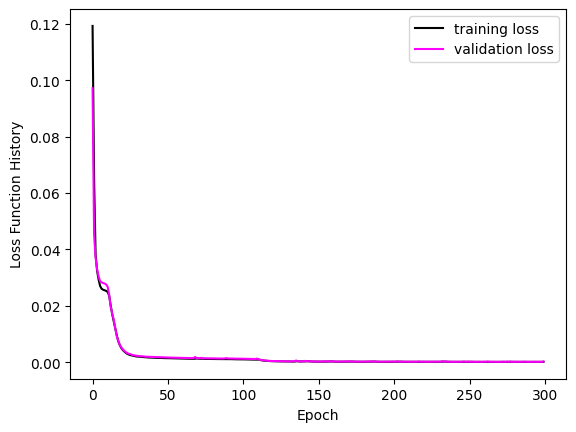

In [36]:
plt = learning_curve(num_epochs, avg_train_loss, avg_val_loss)
plt.title("")
plt.show()
# train_loss.shape, val_loss.shape

## Training autoencoder with gender classifier

We separated our dataset into classes by differentiating between the male and female superheroes, which differ primarily in hair style. We added a classifier head to our encoder using a linear and a sigmoid layer. We use a threshold of 0.5 to determine whether a given superhero emoji is male or female.

Hyper Parameters:
kernel_size = 2  
stride = 2   
padding = 0  
learning_rate = 0.0002   
batch_size = 65  
num_epochs = 300     
lambda (for classifier) = 0.1

Incorporating classification as an auxiliary task improved the performance of our autoencoder, since the model must train for both image reconstruction and classification simultaneously. A potential reason performance might have changed may have been because our autoencoder was more regularized during training from having to perform classification as an auxiliary task, helping to prevent overfitting. An experiment to confirm this speculation might be to train another autoencoder without classification but with L2 regularization, and then compare the performance to the original autoencoder. If the performance is similar, the implication would be that regularization is a key factor in the original autoencoder.

Results:
Final Train Loss: 0.0001278605341212824 
Final Test Loss: 0.00014615646796301007 
Final Classification Accuracy: 1.0

In [24]:
AEModel = autoencoder(2, 2, 0, 100)
AEModel.to(device)
num_epochs = 300
loss_func1 = torch.nn.MSELoss()
loss_func2 = torch.nn.BCELoss()
optimizer = torch.optim.Adam(AEModel.parameters(), lr=0.0002)
lamb = 0.1
avg_train_loss = []
avg_val_loss = []
avg_class_accuracy = []

num_batches = 10
batch_size = len(train) // num_batches
num_trained = num_batches * batch_size
train_image_tensors = [torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)/255 for image in train]

for i in range(num_epochs):
  y_hats = []
  train_loss = 0

  for batch_num in range(num_batches):
    start_idx = batch_num * batch_size
    end_idx = start_idx + batch_size
    image_tensor_batch = train_image_tensors[start_idx:end_idx]
    image_tensor_batch = torch.cat(image_tensor_batch, dim=0)
    image_tensor_batch = image_tensor_batch.to(device)

    output, y_h= AEModel.forward(image_tensor_batch, classify=True)
    loss = loss_func1(output, image_tensor_batch)
    train_loss += loss

    tmp_y = torch.Tensor(np.asarray([train_label[start_idx:end_idx]]).T)
    tmp_y = tmp_y.to(device)
    loss += lamb * loss_func2(y_h, tmp_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_h = y_h.cpu().detach().numpy()
    y_h = y_h.flatten()
    y_hats.append(y_h > 0.5)

  avg_train_loss.append((train_loss/num_batches).item())
  #validation loss
  val_loss = 0
  for i,val_image in enumerate(validation):
    # Reformat into the same format expected by nn.conv2d
    val_image_tensor = torch.Tensor(val_image).permute(2, 0, 1).unsqueeze(0)
    val_image_tensor /= 255
    val_image_tensor = val_image_tensor.to(device)
    val_output, val_y_h = AEModel.forward(val_image_tensor, classify=True)
    tmp_loss = loss_func1(val_output, val_image_tensor)
    val_tmp_y = torch.Tensor(np.asarray([[validation_label[i]]]))
    val_tmp_y = val_tmp_y.to(device)
    tmp_loss += loss_func2(val_y_h, val_tmp_y)
    val_loss += tmp_loss
  avg_val_loss.append((val_loss/len(validation)).item())

  y_hats = np.asarray(y_hats, dtype=int).flatten()
  avg_class_accuracy.append(np.mean(y_hats == np.asarray(train_label[:num_trained])))


print("Loss:", str(avg_train_loss[-1]))
print("Accuracy for man/woman:", np.mean(y_hats == np.asarray(train_label[:num_trained])))

### TESTING
test_loss = 0
for j, image in enumerate(test):
  # Reformat into the same format expected by nn.conv2d
  image_tensor = torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)
  image_tensor /= 255
  image_tensor = image_tensor.to(device)
  output = AEModel.forward(image_tensor, classify=False)
  test_loss += loss_func1(output, image_tensor)

test_loss /= len(test)
print("Test Loss:", str(test_loss.item()))


Loss: 0.0001278605341212824
Accuracy for man/woman: 1.0
Test Loss: 0.00014615646796301007


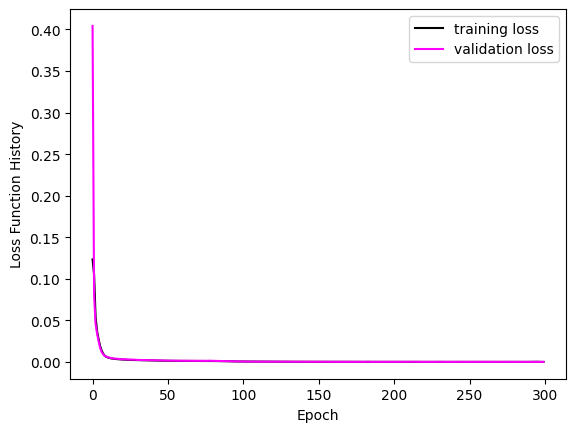

In [25]:
replt = learning_curve(num_epochs, avg_train_loss, avg_val_loss)
plt.title("")
plt.show()

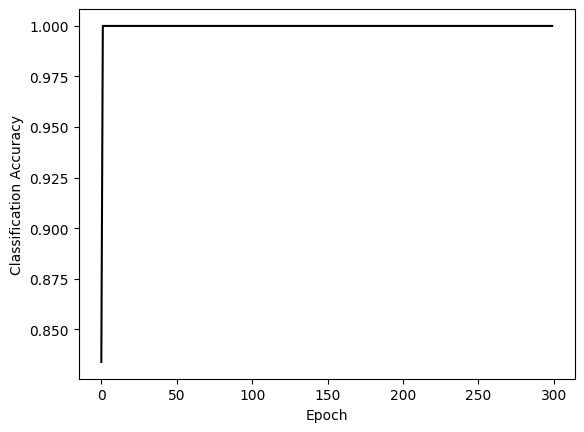

In [26]:
replt = classification_accuracy_curve(num_epochs, avg_class_accuracy)
plt.title("")
plt.show()

## Combining Emojis

We selected the male hair style attribute by using the male superhero emoji and composed it with a female superhero of different hair and skin color. After the two desired emojis were converted to tensors, they were passed into a custom “combine” function of our autoencoder. In this function, each image is encoded, and all encoded image vectors are then summed and divided by the total number of images to calculate the average latent representation of all images. Finally, this average encoding was decoded to extract the final result.

Our composite image appears to have successfully composed the average representation of the two original emojis. Aspects of both original hair styles can be seen in the final image’s hair, and the skin tone of the final image could also be described as a mix of those of the originals. To improve the quality of our generated image, we might attempt to further apply data augmentation techniques to artificially increase the size and diversity of our training dataset by performing common augmentations such as rotation, flipping, scaling, and color transformations. With a larger and more diverse dataset, the model would be more robust and regularized and would likely be able to generate a higher quality image.


Original 1


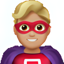

Original 2


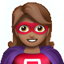

Combined Image


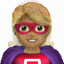

In [27]:
image_tensor1 = torch.Tensor(images[2]).permute(2, 0, 1).unsqueeze(0)/255
image_tensor2 = torch.Tensor(images[9]).permute(2, 0, 1).unsqueeze(0)/255
image_tensor1 = image_tensor1.to(device)
image_tensor2 = image_tensor2.to(device)
output = AEModel.combine([image_tensor1, image_tensor2])

new_image = (torch.squeeze(output.cpu(), 0).permute(1,2,0)).detach().numpy()
new_image *= 255
new_image = new_image.astype(np.uint8)
new_image = Image.fromarray(new_image)

print("Original 1")
display(Image.fromarray(images[2]))
print("Original 2")
display(Image.fromarray(images[9]))
print("Combined Image")
display(new_image)


## Examples of our autoencoder "reconstructing image"

Original Image:


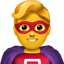

Reconstructed Image:


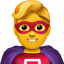

Original Image:


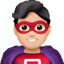

Reconstructed Image:


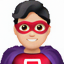

Original Image:


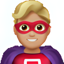

Reconstructed Image:


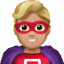

Original Image:


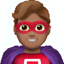

Reconstructed Image:


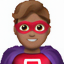

Original Image:


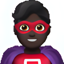

Reconstructed Image:


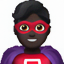

Original Image:


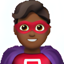

Reconstructed Image:


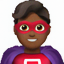

Original Image:


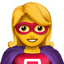

Reconstructed Image:


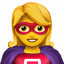

Original Image:


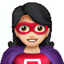

Reconstructed Image:


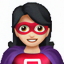

Original Image:


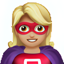

Reconstructed Image:


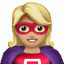

Original Image:


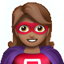

Reconstructed Image:


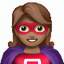

Original Image:


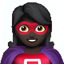

Reconstructed Image:


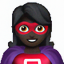

Original Image:


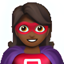

Reconstructed Image:


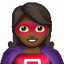

In [54]:
for image in images:
  image_tensor = torch.Tensor(image).permute(2, 0, 1).unsqueeze(0)/255
  image_tensor = image_tensor.to(device)
  output = AEModel.forward(image_tensor)

  reconstructed_image = (torch.squeeze(output.cpu(), 0).permute(1,2,0)).detach().numpy()
  reconstructed_image *= 255
  reconstructed_image = reconstructed_image.astype(np.uint8)
  reconstructed_image = Image.fromarray(reconstructed_image)
  print("Original Image:")
  display(Image.fromarray(image))
  print("Reconstructed Image:")
  display(reconstructed_image)